In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import seaborn as sns
import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
smote_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
#smote_suffix = 'SMOTE_train_test_70-30_min4_kneighbors2'
#smote_suffix = 'SMOTE_train_test_60-40_min8_kneighbors4'
#smote_suffix = 'SMOTE_train_test_70-30_min8_kneighbors5'
#smote_suffix = 'SMOTE_train_test_80-20_min4_kneighbors2'
#smote_suffix = 'SMOTE_train_test_80-20_min8_kneighbors5'
suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"

In [3]:
full_ann_properties_df = pd.read_csv(f'../loci_dbs/alerce_cut/full_ann101_properties_df_{suffix}.csv', index_col=0)
full_ann_properties_df

,ann=0_ztfid,ann=1_ztfid,ann=2_ztfid,ann=3_ztfid,ann=4_ztfid,ann=5_ztfid,ann=6_ztfid,ann=7_ztfid,ann=8_ztfid,ann=9_ztfid,...,ann=91_spec_z,ann=92_spec_z,ann=93_spec_z,ann=94_spec_z,ann=95_spec_z,ann=96_spec_z,ann=97_spec_z,ann=98_spec_z,ann=99_spec_z,ann=100_spec_z
ZTF20aaybwth,ZTF20aaybwth,ZTFabc15843,ZTFabc80732,ZTFabc27878,ZTFabc89458,ZTFabc76879,ZTFabc55090,ZTFabc95565,ZTF21abexmbi,ZTFabc97861,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,0.1
ZTF21abhvfrj,ZTF21abhvfrj,ZTF21aarlqgt,ZTFabc40828,ZTFabc01145,ZTFabc45040,ZTFabc45112,ZTFabc82423,ZTFabc33717,ZTFabc54501,ZTFabc41496,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
ZTF20acngnvf,ZTF20acngnvf,ZTF21aahdrvq,ZTF20acusjnl,ZTF21acjeqpb,ZTF18acttqzo,ZTF20aansxav,ZTF19abeievz,ZTF21achqnfn,ZTF21achnqdo,ZTFabc78281,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
ZTF20aciucub,ZTF20aciucub,ZTFabc48284,ZTF18abscghc,ZTF21aavouex,ZTFabc19121,ZTF21aatuuiz,ZTFabc98284,ZTF21aawjiss,ZTF21aagkzxe,ZTFabc50023,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
ZTF21abcfnuk,ZTF21abcfnuk,ZTFabc32968,ZTFabc77151,ZTFabc41315,ZTFabc37219,ZTFabc89740,ZTFabc56219,ZTFabc98323,ZTFabc06057,ZTF21aagrhot,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,ZTF20acupxyy,ZTFabc46574,ZTFabc39788,ZTFabc87577,ZTFabc20810,ZTFabc81179,ZTF21aaoglbq,ZTFabc40354,ZTFabc19936,ZTFabc93008,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
ZTF21aarzxnb,ZTF21aarzxnb,ZTF21abdhbrh,ZTF20acpmeuc,ZTF21acjvkga,ZTF21aawkuqe,ZTF20acuxlgx,ZTF20acppzxx,ZTFabc45112,ZTF18acbzvow,ZTF21aaigndt,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.14,-99.00,-99.0
ZTF18acsxjhc,ZTF18acsxjhc,ZTFabc22118,ZTFabc11741,ZTF18aczersc,ZTFabc69059,ZTFabc53861,ZTFabc38391,ZTFabc97081,ZTFabc07540,ZTFabc08966,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.0
ZTF21aatklhw,ZTF21aatklhw,ZTFabc08837,ZTFabc24314,ZTFabc29227,ZTFabc17433,ZTFabc28849,ZTFabc81455,ZTFabc03685,ZTFabc82625,ZTFabc14853,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,0.09,-99.0


In [4]:
df_selected = full_ann_properties_df.iloc[:, 303:404]
df_selected

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls,...,ann=91_tns_cls,ann=92_tns_cls,ann=93_tns_cls,ann=94_tns_cls,ann=95_tns_cls,ann=96_tns_cls,ann=97_tns_cls,ann=98_tns_cls,ann=99_tns_cls,ann=100_tns_cls
ZTF20aaybwth,None,SN II,SN IIn,SN IIn,SN IIn,SN IIn,SN II,SN IIn,None,SN IIn,...,None,SN II,SN II,None,SN IIn,SN IIn,SN IIn,None,TDE,SN Ia
ZTF21abhvfrj,None,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,SN II,...,SN Ia,SN II,SN IIb,SN IIn,SN IIn,SN Ia-91T-like,None,SN IIn,SN IIn,None
ZTF20acngnvf,None,None,None,None,None,None,None,None,None,SN IIn,...,SLSN-II,SN IIn,None,SLSN-II,SLSN-II,SN IIn,SLSN-II,None,SLSN-II,SLSN-II
ZTF20aciucub,None,SN II,None,None,SN Ia,None,SN Ia,SN Ia,None,SN II,...,SN IIP,SN Ia,SN IIP,SN Ic-BL,SN IIP,SN IIP,None,SN IIP,SN II,SN IIP
ZTF21abcfnuk,None,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,...,SN IIn,SN IIn,None,SN Ia-91T-like,SN IIn,SN Ia,SN IIn,SN Ia,SN IIn,SN IIn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,None,TDE,TDE,TDE,TDE,TDE,None,TDE,TDE,TDE,...,SN II,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE,TDE
ZTF21aarzxnb,None,None,None,None,None,None,None,SN II,None,None,...,SN Ia,SN Ia,None,SN II,SN Ia,None,SN II,SN Ia,None,None
ZTF18acsxjhc,None,SN IIn,SN IIn,None,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,SN IIn,...,SN II,SN II,SN IIb,SN IIb,SN Ib,SN Ib,SN IIb,SN Ib,SN Ib,SN IIb
ZTF21aatklhw,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,TDE,TDE,TDE,TDE,...,SN Ia-91T-like,SN II,TDE,SN Ia,SN Ia,SN Ia,TDE,SN Ia-91T-like,SN Ia,TDE


In [5]:
# get the most common value per row
most_common = df_selected.mode(axis=1)

# create a new DataFrame with the original ann=0_tns_cls column and the most_common column
new_df = pd.concat([df_selected['ann=0_tns_cls'], most_common], axis=1)

# rename the most_common column
new_df.rename(columns={0: 'most_common_cls_ann=1-100'}, inplace=True)


# Find most commonly occuring class label in ANN=1-100
freq_df = pd.DataFrame()
freq_df['ann=0_tns_cls'] = new_df['ann=0_tns_cls']
freq_df['most_common_cls_ann=1-100'] = new_df['most_common_cls_ann=1-100']
freq_df

,ann=0_tns_cls,most_common_cls_ann=1-100
ZTF20aaybwth,None,SN IIn
ZTF21abhvfrj,None,SN II
ZTF20acngnvf,None,SLSN-II
ZTF20aciucub,None,SN Ic-BL
ZTF21abcfnuk,None,SN Ia
...,...,...
ZTF20acupxyy,None,TDE
ZTF21aarzxnb,None,None
ZTF18acsxjhc,None,SN IIn
ZTF21aatklhw,SN Ia,TDE


In [6]:
# Or, just use ANN=1

ann0_ann1_df = full_ann_properties_df[['ann=0_tns_cls', 'ann=1_tns_cls']]
ann0_ann1_df

,ann=0_tns_cls,ann=1_tns_cls
ZTF20aaybwth,None,SN II
ZTF21abhvfrj,None,SN II
ZTF20acngnvf,None,None
ZTF20aciucub,None,SN II
ZTF21abcfnuk,None,SN Ia
...,...,...
ZTF20acupxyy,None,TDE
ZTF21aarzxnb,None,None
ZTF18acsxjhc,None,SN IIn
ZTF21aatklhw,SN Ia,SN Ia


# TODO: instead of ANN-1, do most common occurring class out of all ANNs (regardless of dist) --> Not as good. Over emphasizes minority classes, part for Ia

#### also, say prioritize the classes of spec ANN matches? like double weight them, or something? (spec should be more highly values as ANN match than fake ANN match) --> NO, because again bias and favors majority classes (Ia)

In [7]:
#title = 'freq_mode_cls_ANN=1-100'
title = 'first_cls_ANN=1-100'

In [8]:
def plot_conf_matrix(y_test, y_pred, labels, title, kind, figsize=(20, 14)):
    if kind == 'completeness':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    if kind == 'purity':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='pred')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap, annot=annotations, fmt='s', cmap='Blues', vmin=0, vmax=1, annot_kws={"fontsize":18})
    plt.title(title, fontsize=24)
    plt.ylabel('True class', fontsize=24)
    plt.xlabel('Predicted class', fontsize=24)
    #plt.show()

### All classes, with None

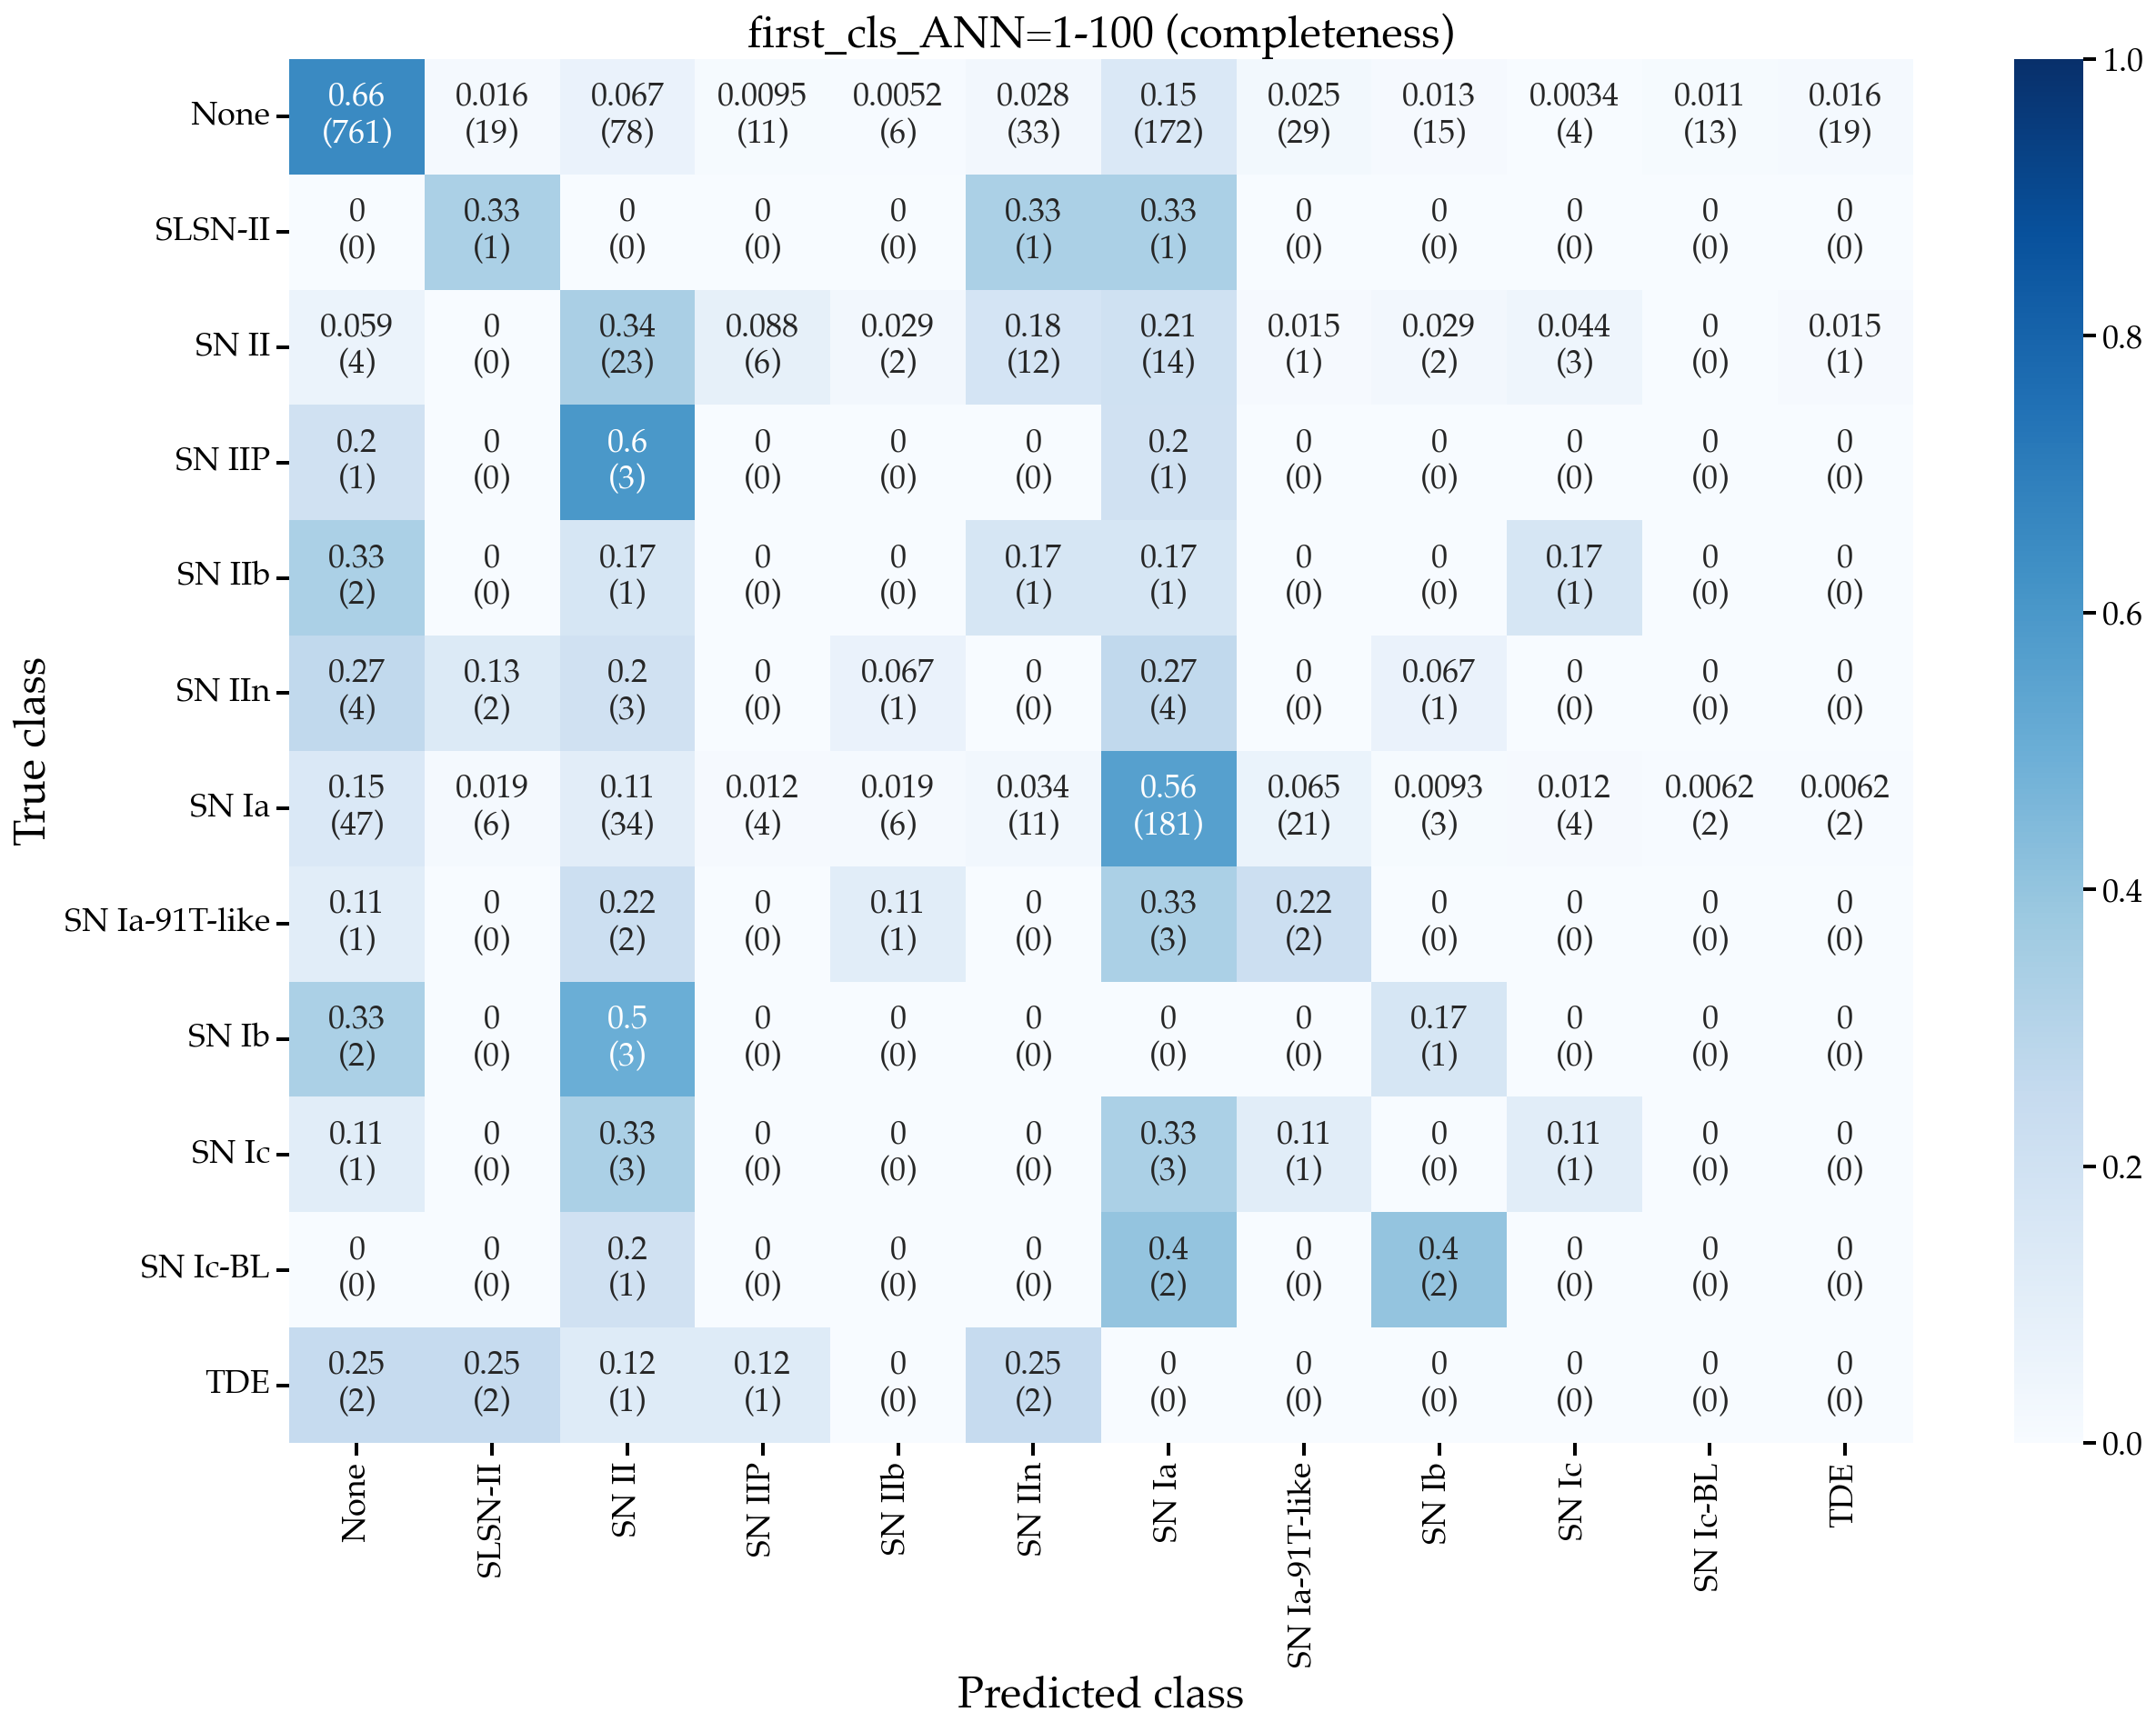

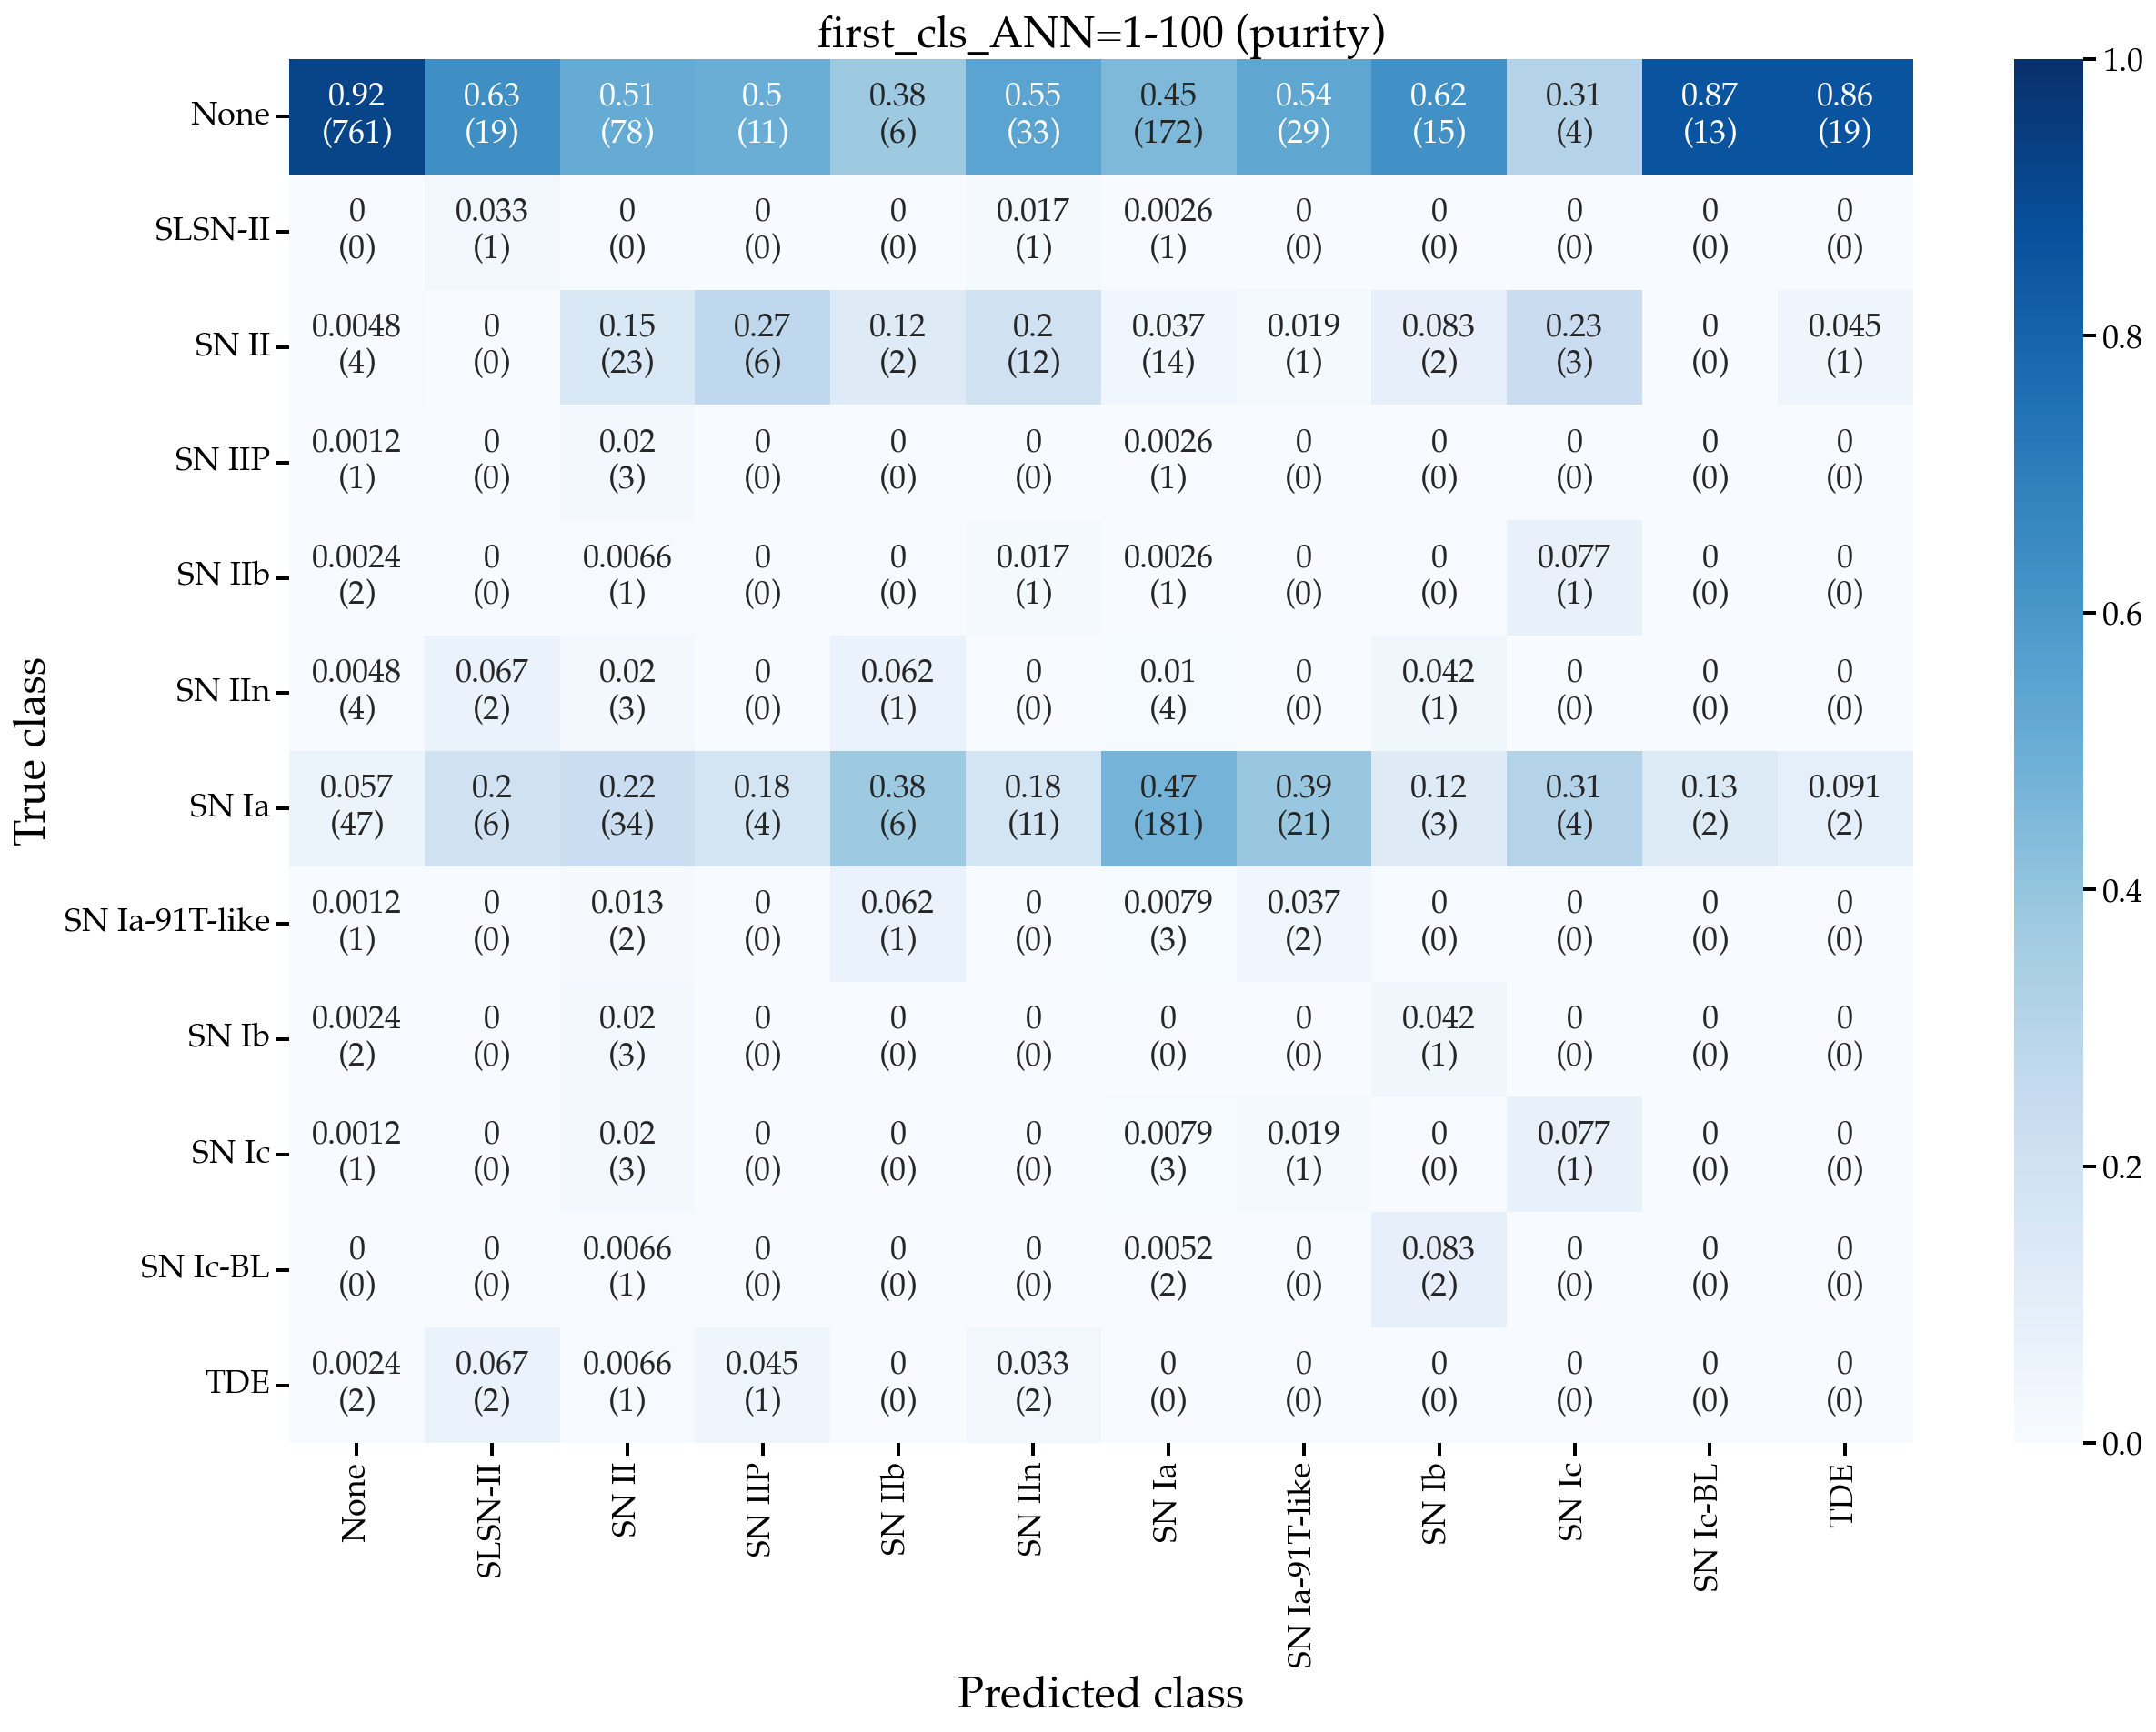

In [9]:
# Confusion matrices
df = ann0_ann1_df #freq_df # ann0_ann1_df
true_labels = np.array(df['ann=0_tns_cls'])
predicted_labels = np.array(df['ann=1_tns_cls']) #np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND)
    plt.savefig(f'../figures/graphs/{suffix}/confmatrix_nclasses={nclasses}_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

### replace None with first ANN class that is not None

In [10]:
def find_first_class_after_None_label_df(df, ann_num):
    # loop through each row
    for index, row in df.iterrows():
        # check if "None" is present in "ann=1_tns_cls"
        if row["ann=1_tns_cls"] == "None":
            # loop through the subsequent columns
            for col in df.columns[2:]:
                # check if the value is not "None"
                if row[col] != "None":
                    # update the value of "ann=1_tns_cls" with the first non-"None" value found
                    df.loc[index, "ann=1_tns_cls"] = row[col]
                    # break out of the loop and move to the next row
                    break
    # replace any remaining "None" values with NaN
    #df.replace("None", np.nan, inplace=True)

    df = df.iloc[:, :ann_num]
    return df

def find_first_class_after_None_label_df(df, ann_num):
    # loop through each row
    for index, row in df.iterrows():
        # check if "None" is present in "ann=1_tns_cls"
        if row["most_common_cls_ann=1-100"] == "None":
            # loop through the subsequent columns
            for col in df.columns[2:]:
                # check if the value is not "None"
                if row[col] != "None":
                    # update the value of "ann=1_tns_cls" with the first non-"None" value found
                    df.loc[index, "most_common_cls_ann=1-100"] = row[col]
                    # break out of the loop and move to the next row
                    break
    # replace any remaining "None" values with NaN
    #df.replace("None", np.nan, inplace=True)

    df = df.iloc[:, :ann_num]
    return df

In [11]:
full_ann_tns_cls_df = full_ann_properties_df.iloc[:, 303:404]

ann0_ann1_df_replaceNone = find_first_class_after_None_label_df(df=full_ann_tns_cls_df, ann_num=2)
#ann0_ann1_df_replaceNone = find_first_class_after_None_label_df(df=freq_df, ann_num=2)
ann0_ann1_df_replaceNone

,ann=0_tns_cls,ann=1_tns_cls
ZTF20aaybwth,None,SN II
ZTF21abhvfrj,None,SN II
ZTF20acngnvf,None,SN IIn
ZTF20aciucub,None,SN II
ZTF21abcfnuk,None,SN Ia
...,...,...
ZTF20acupxyy,None,TDE
ZTF21aarzxnb,None,SN II
ZTF18acsxjhc,None,SN IIn
ZTF21aatklhw,SN Ia,SN Ia


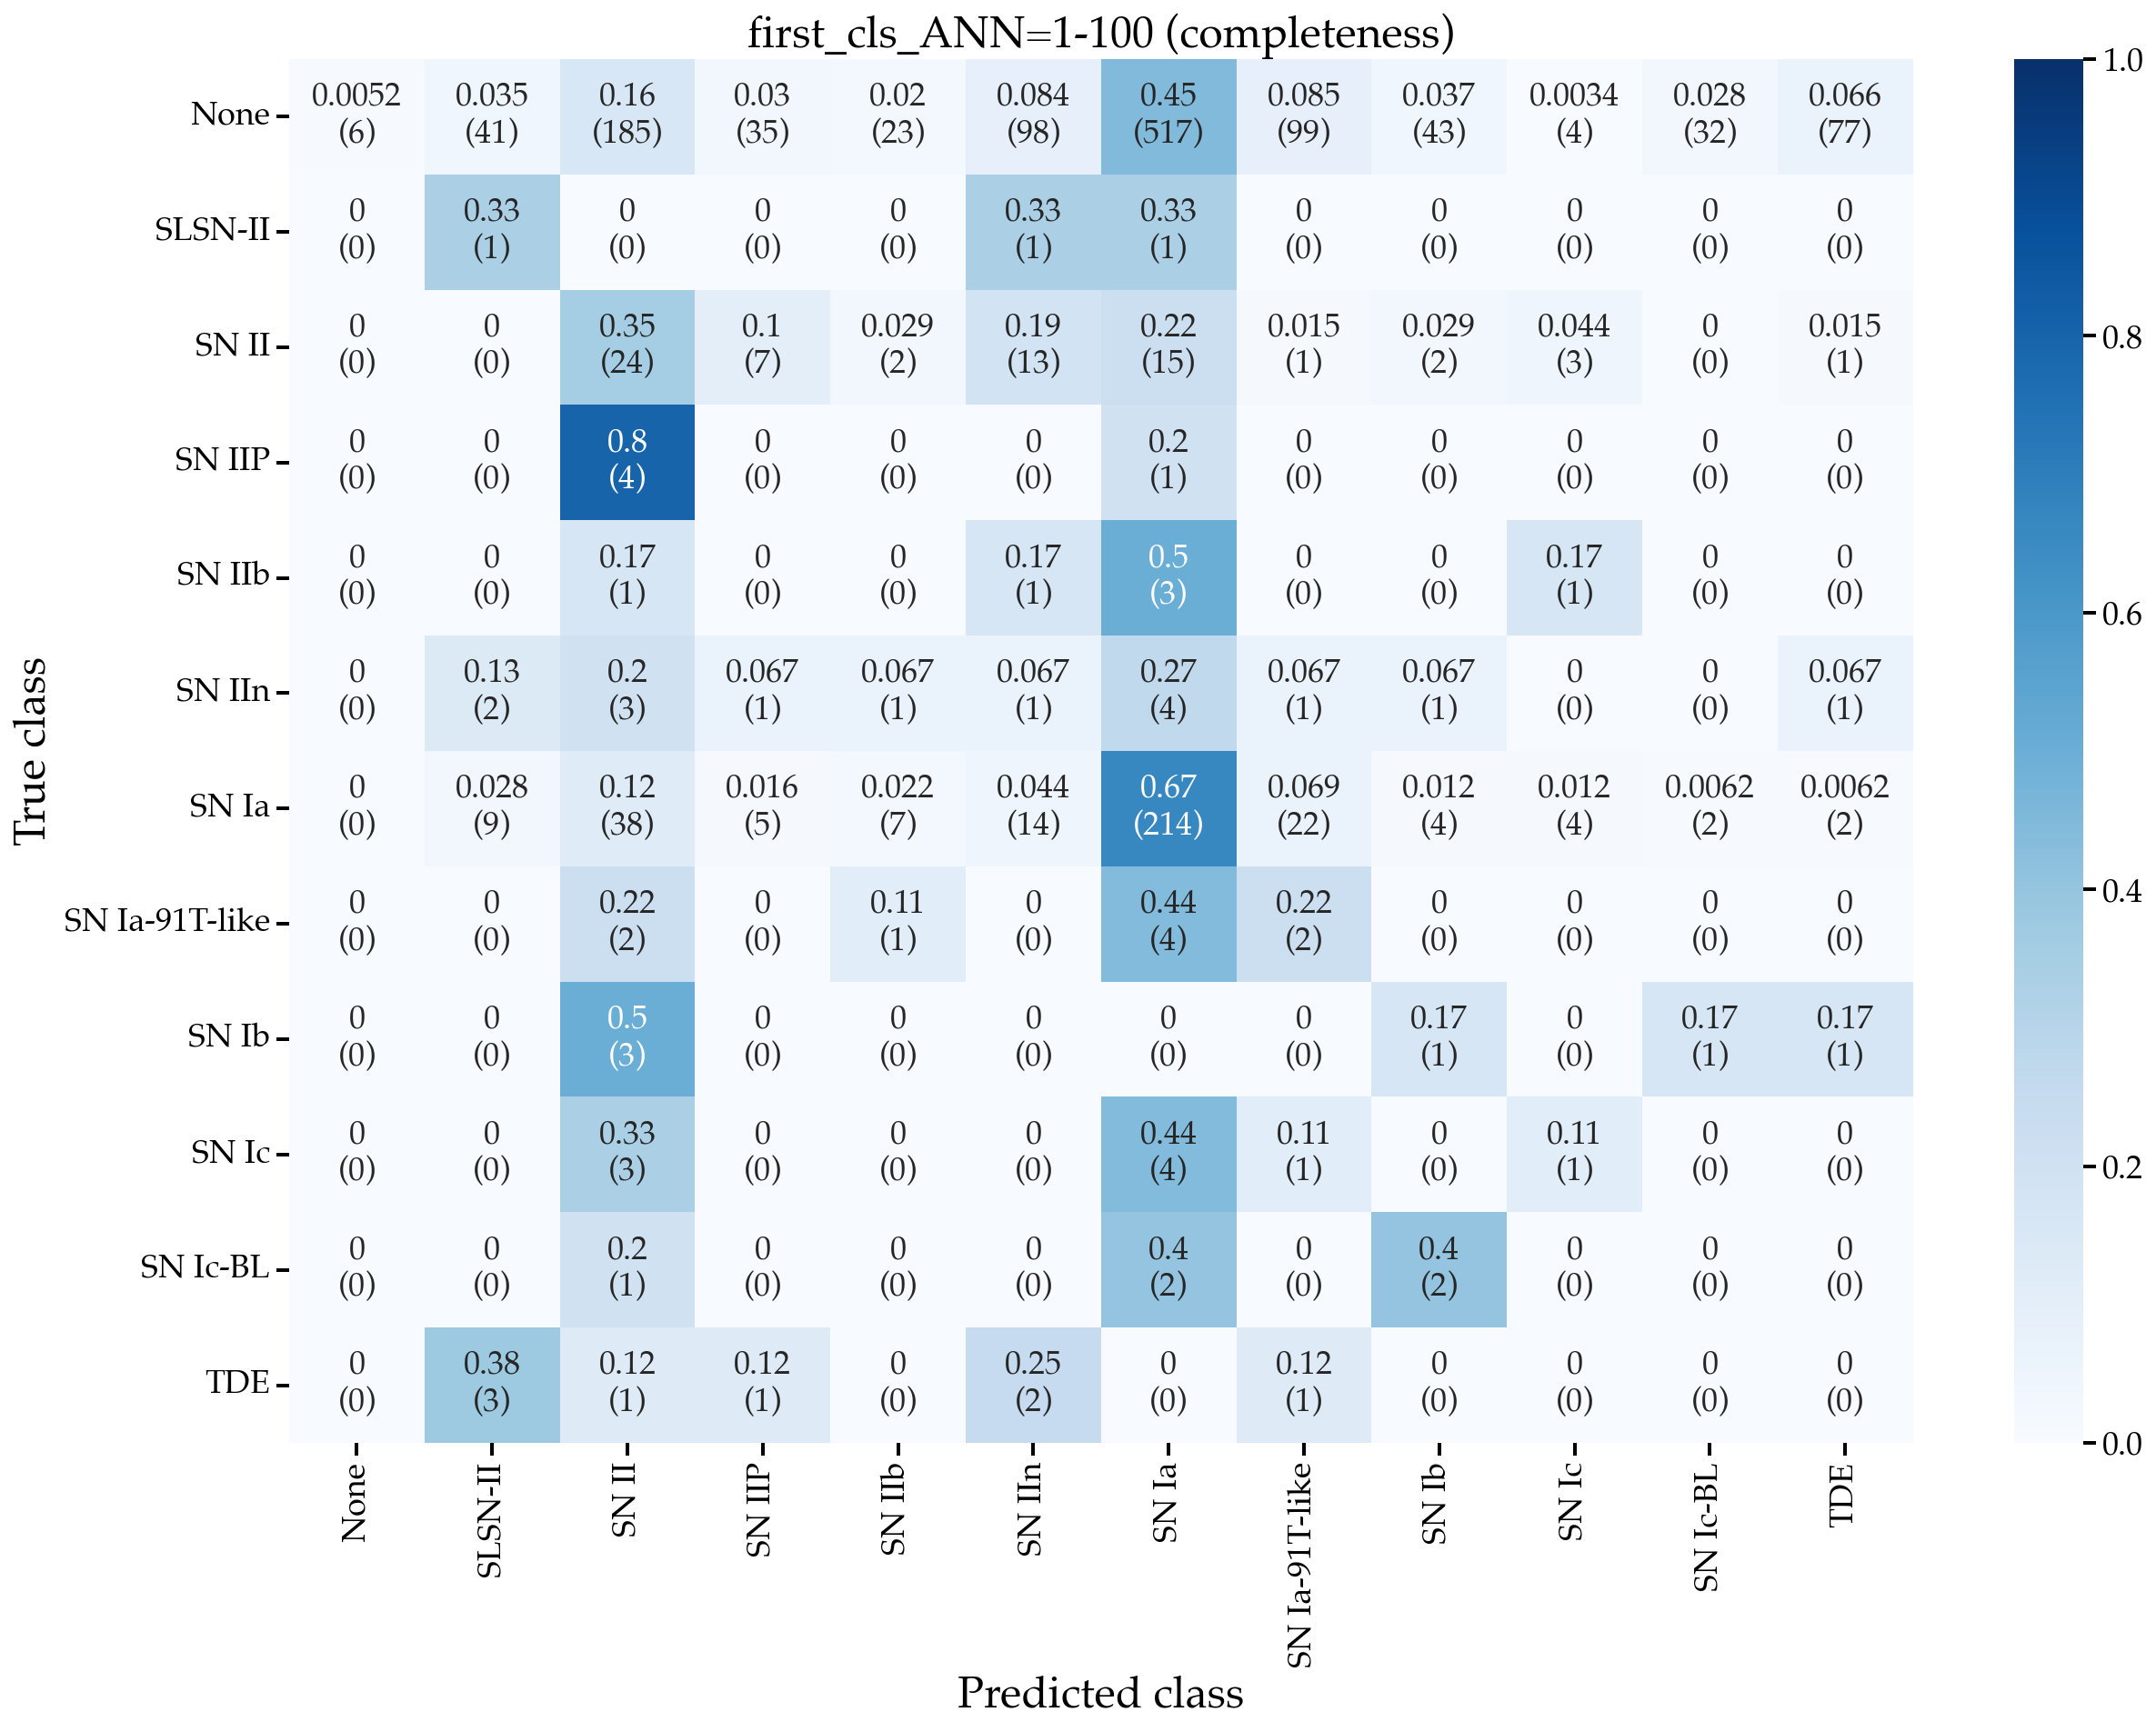

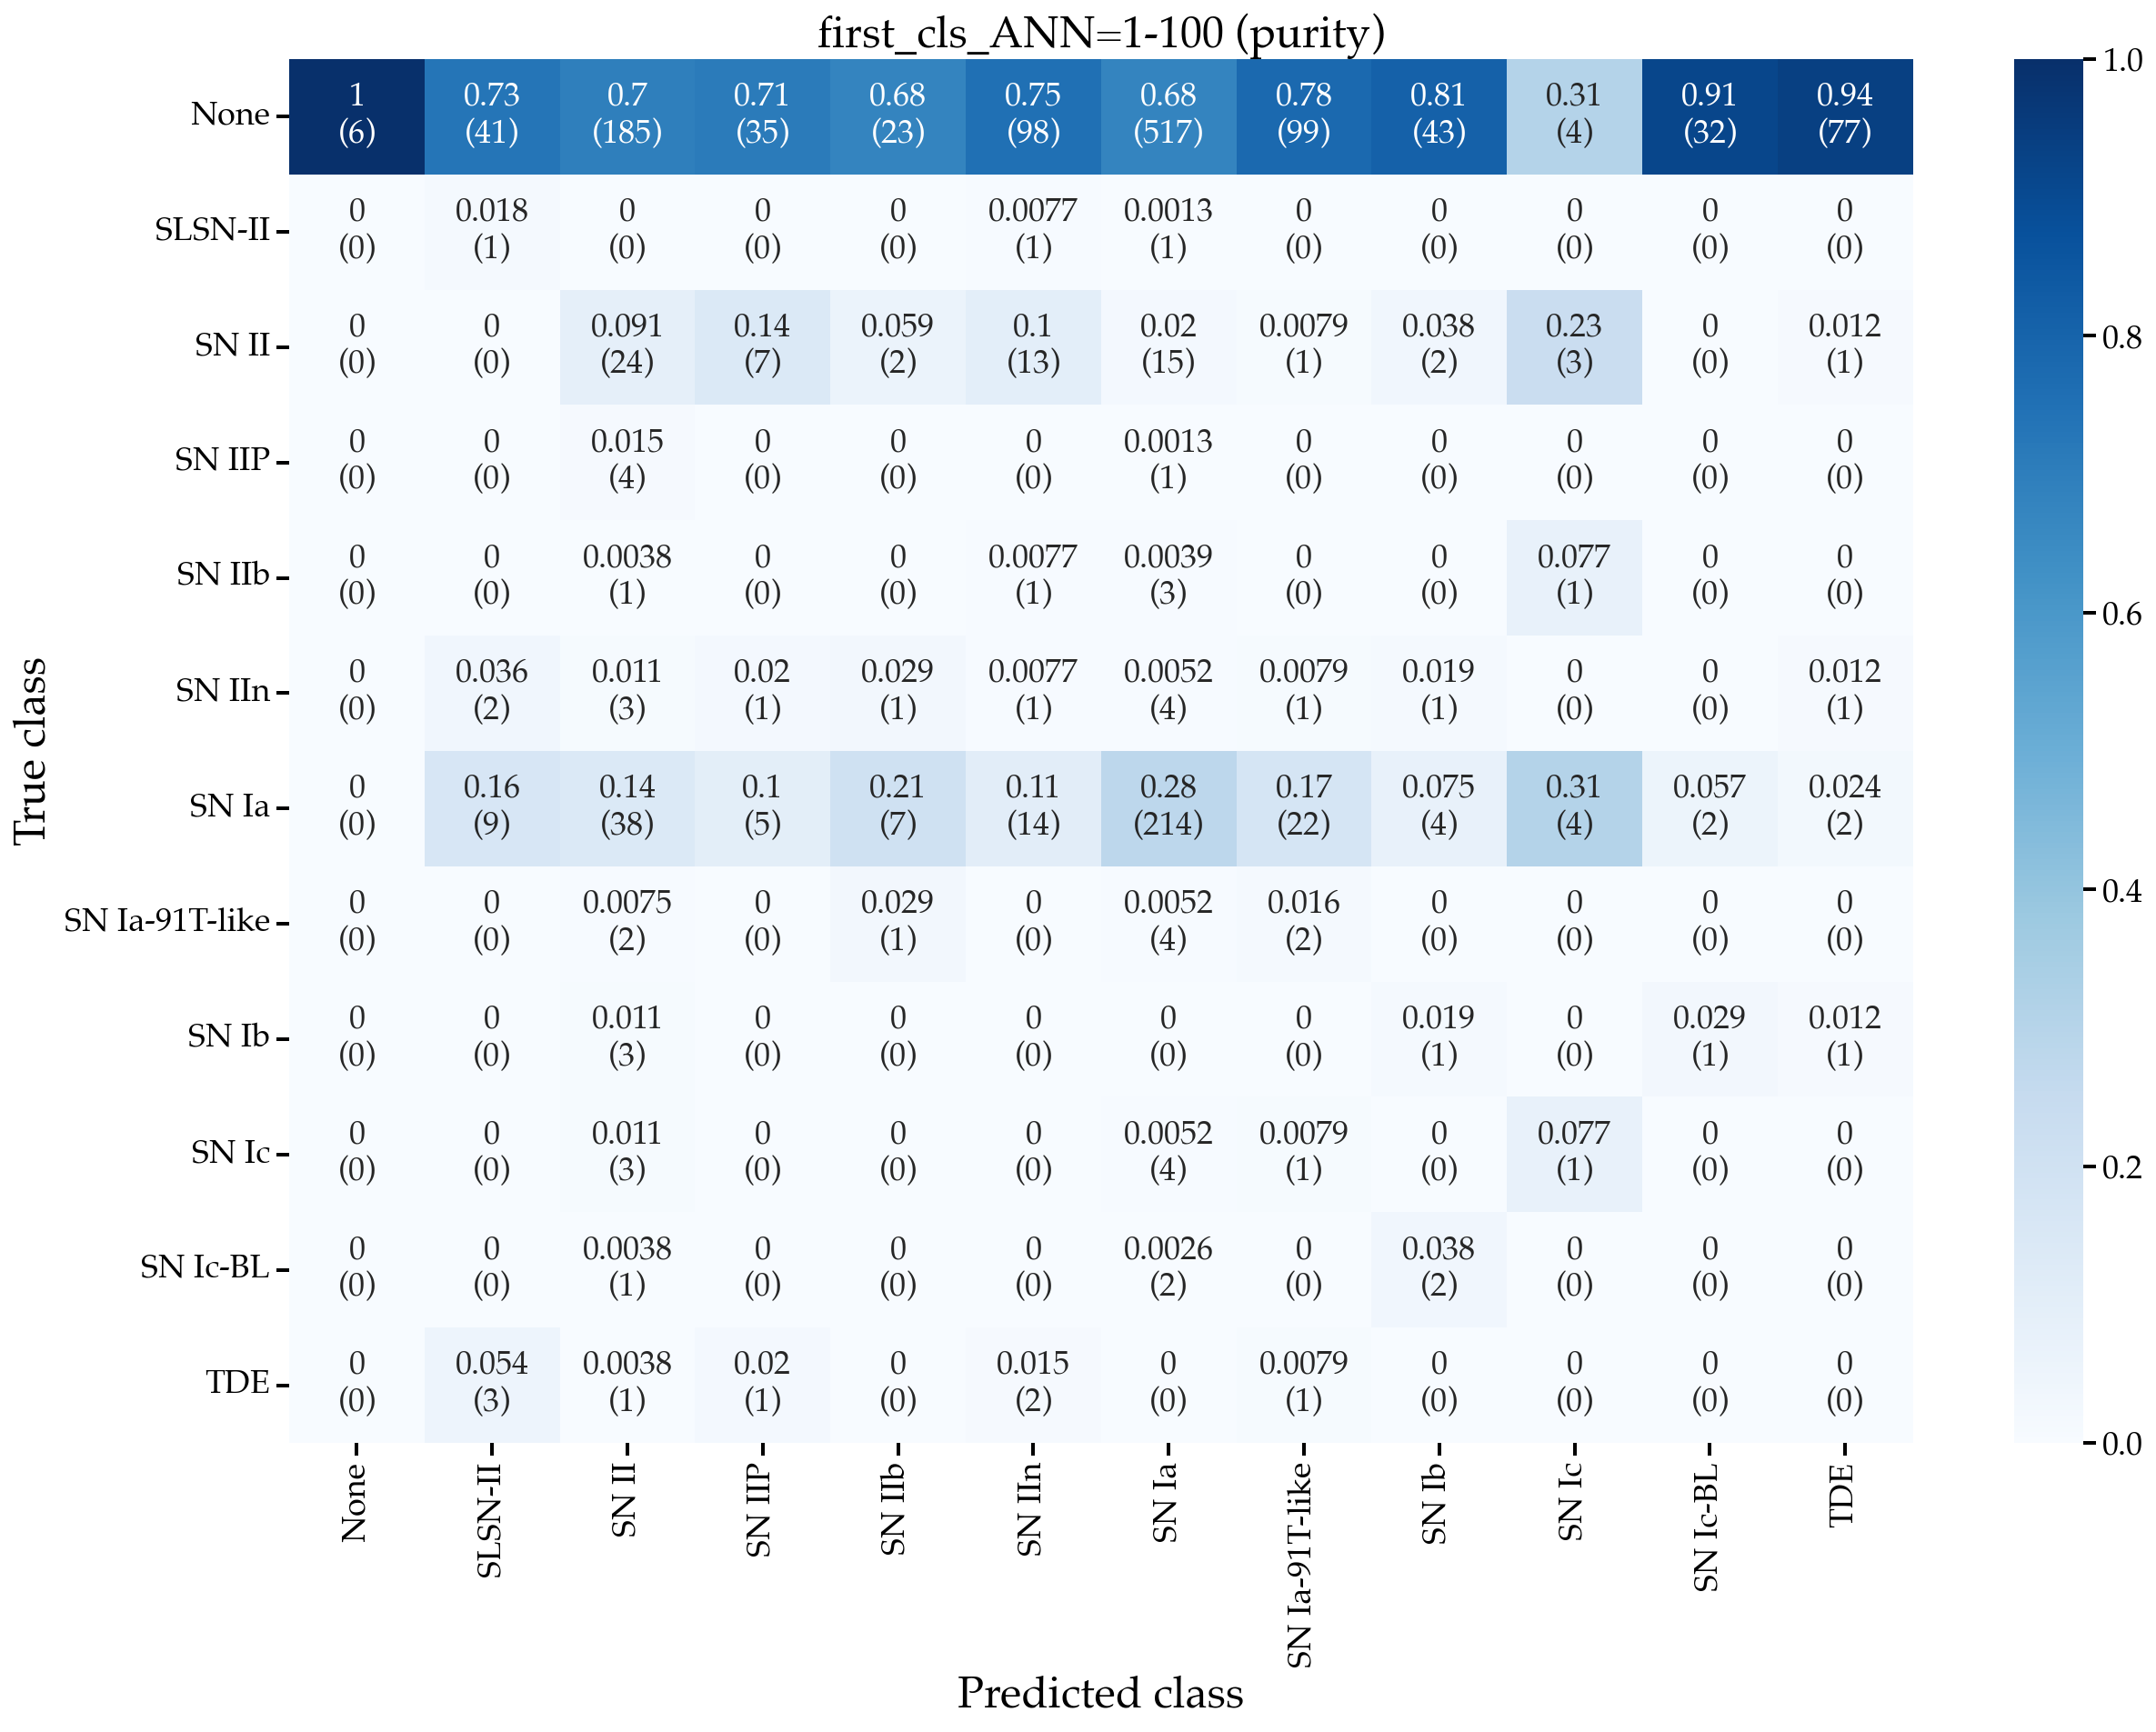

In [12]:
# Confusion matrices
df = ann0_ann1_df_replaceNone
true_labels = np.array(df['ann=0_tns_cls'])
predicted_labels = np.array(df['ann=1_tns_cls']) #np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND)
    plt.savefig(f'../figures/graphs/{suffix}/confmatrix_nclasses={nclasses}_replaceNone_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

### Throw out None altogether

In [13]:
ann0_ann1_df_noNone = ann0_ann1_df[ann0_ann1_df['ann=0_tns_cls'] != 'None']
#ann0_ann1_df_noNone = freq_df[freq_df['ann=0_tns_cls'] != 'None']

ann0_ann1_df_noNone

,ann=0_tns_cls,ann=1_tns_cls
ZTF21aazebgh,SN Ia,SN Ia
ZTF21acgxypn,SN Ic-BL,SN Ib
ZTF19aapqqrb,SN Ia,None
ZTF21aasbxng,SN Ia,SN Ia
ZTF21aaglgcb,SN Ia,SN Ia
...,...,...
ZTF21acdalyp,SN Ia-91T-like,SN Ia
ZTF21abdcauj,SN Ia,SN Ia
ZTF21aaetnfe,SN Ia,SN Ia
ZTF21acgzwsc,SN Ia,SN IIb


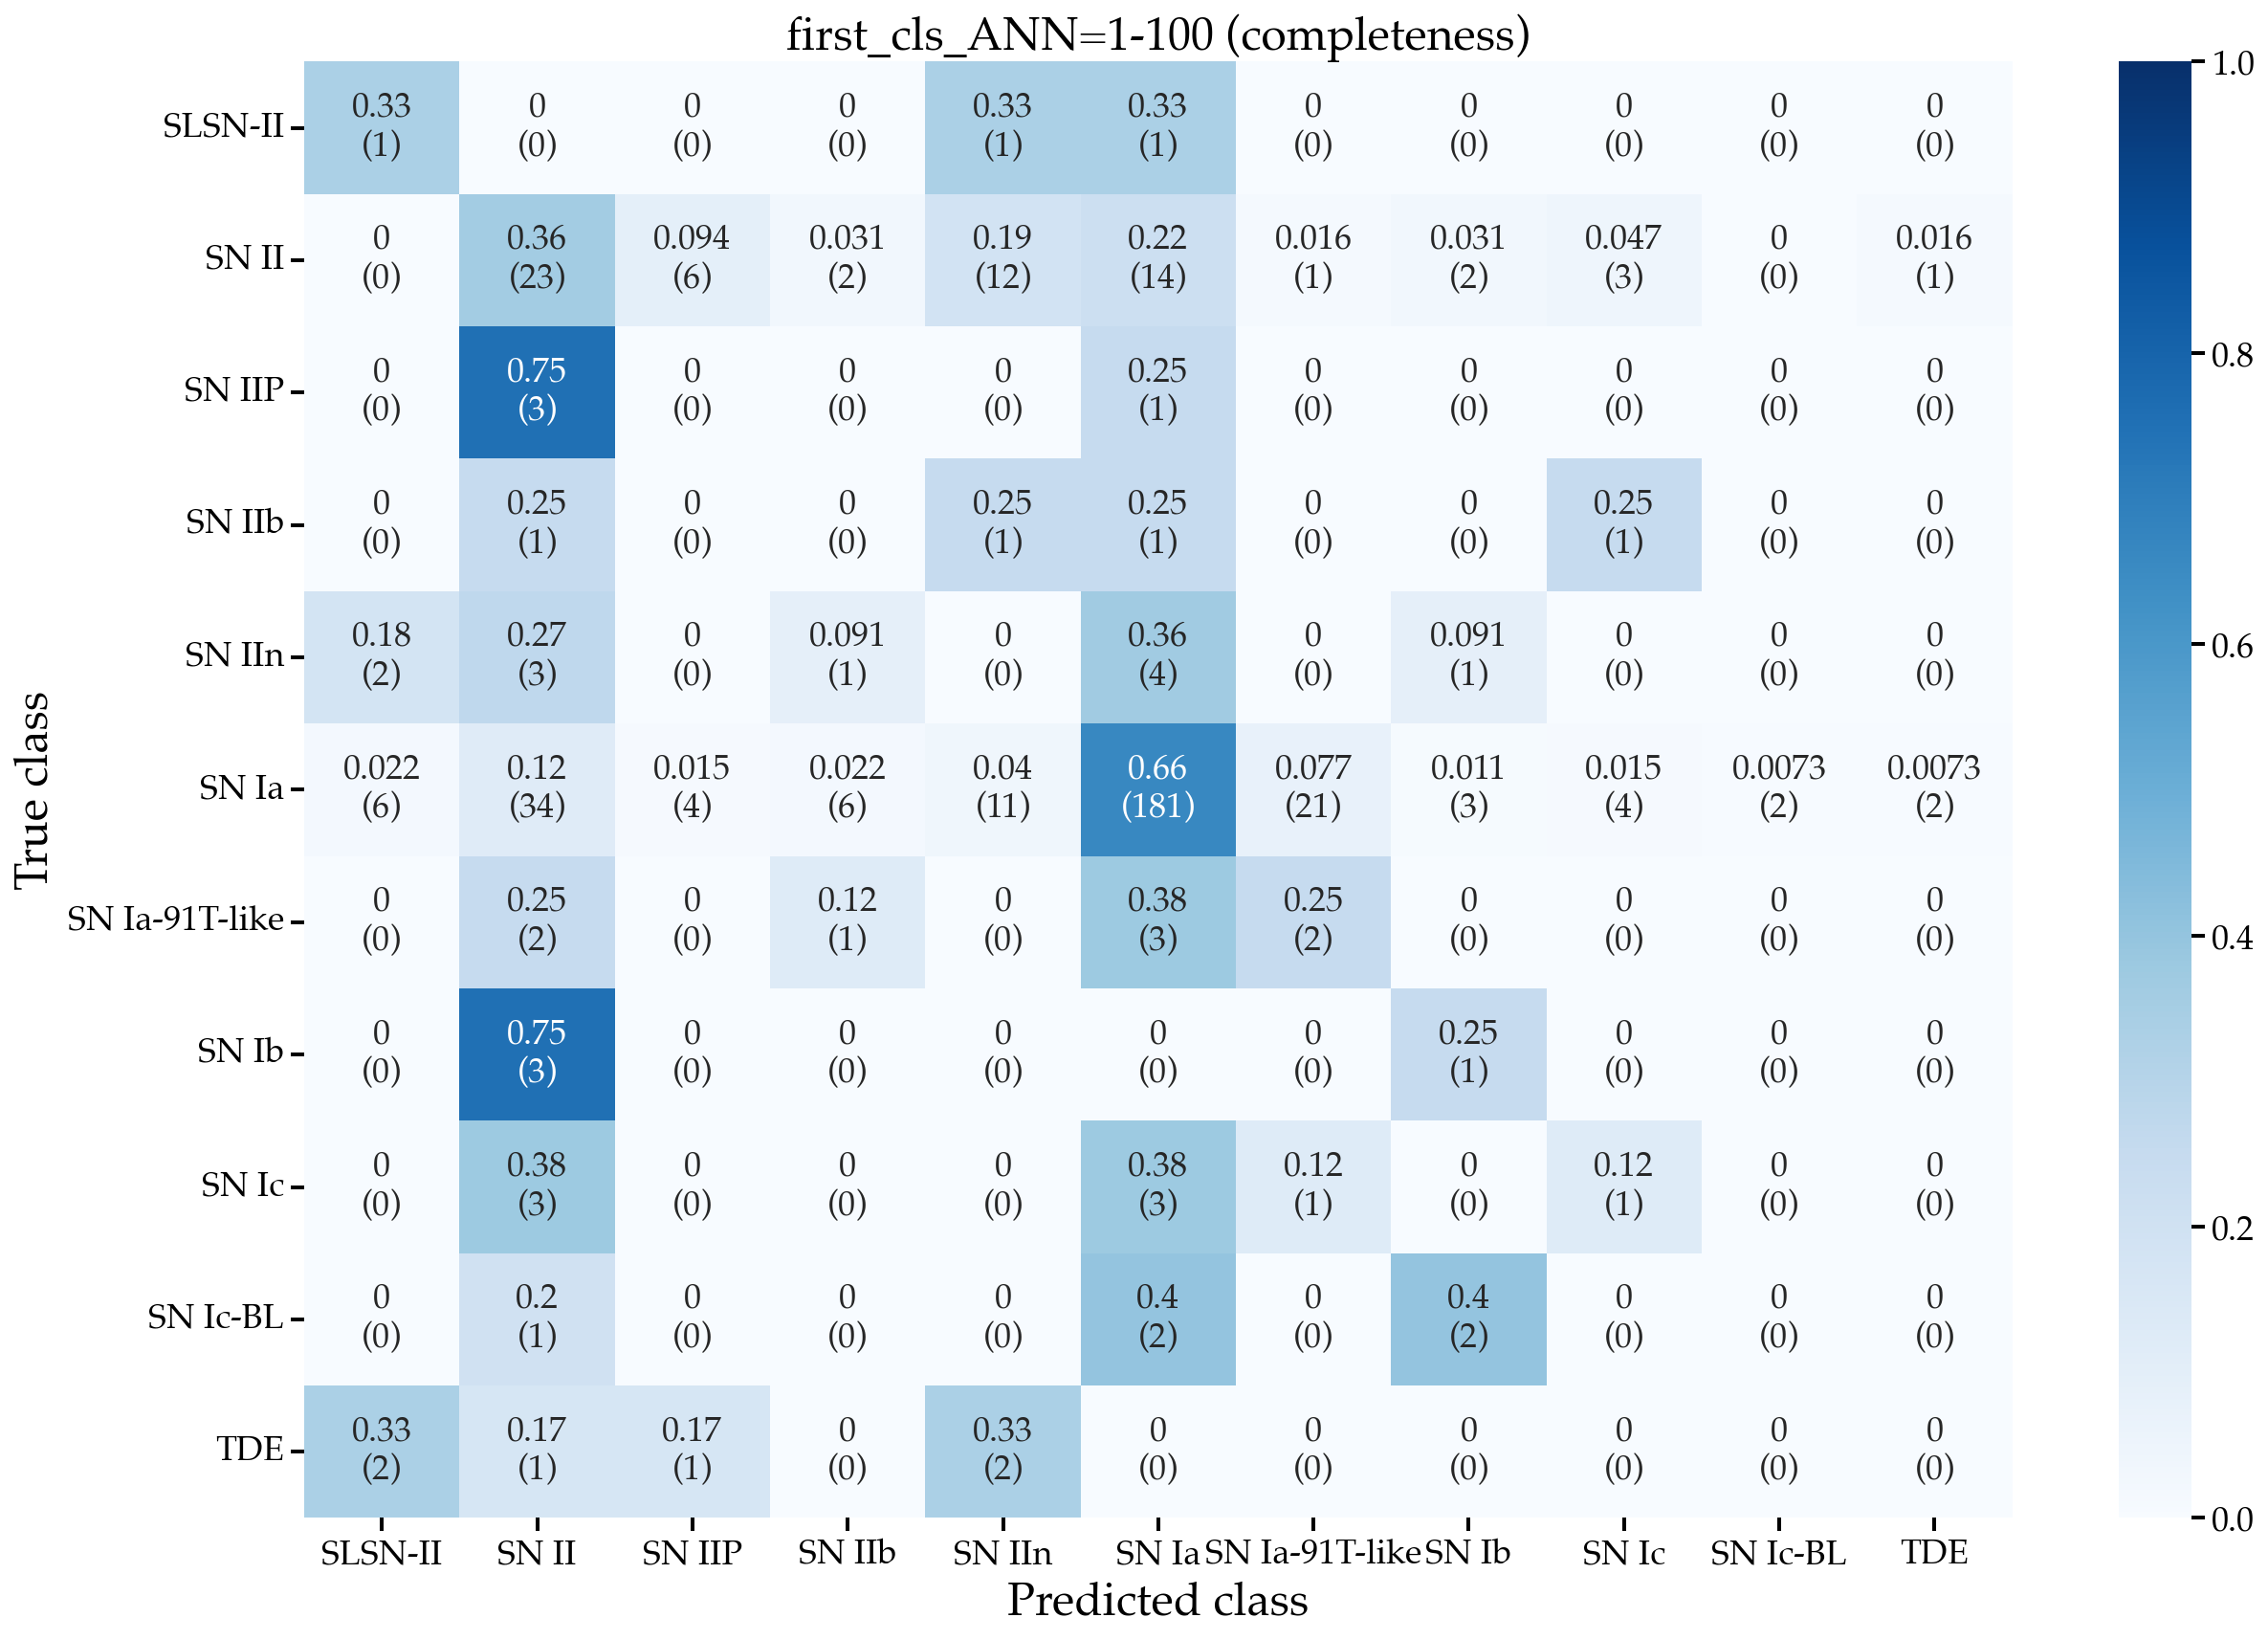

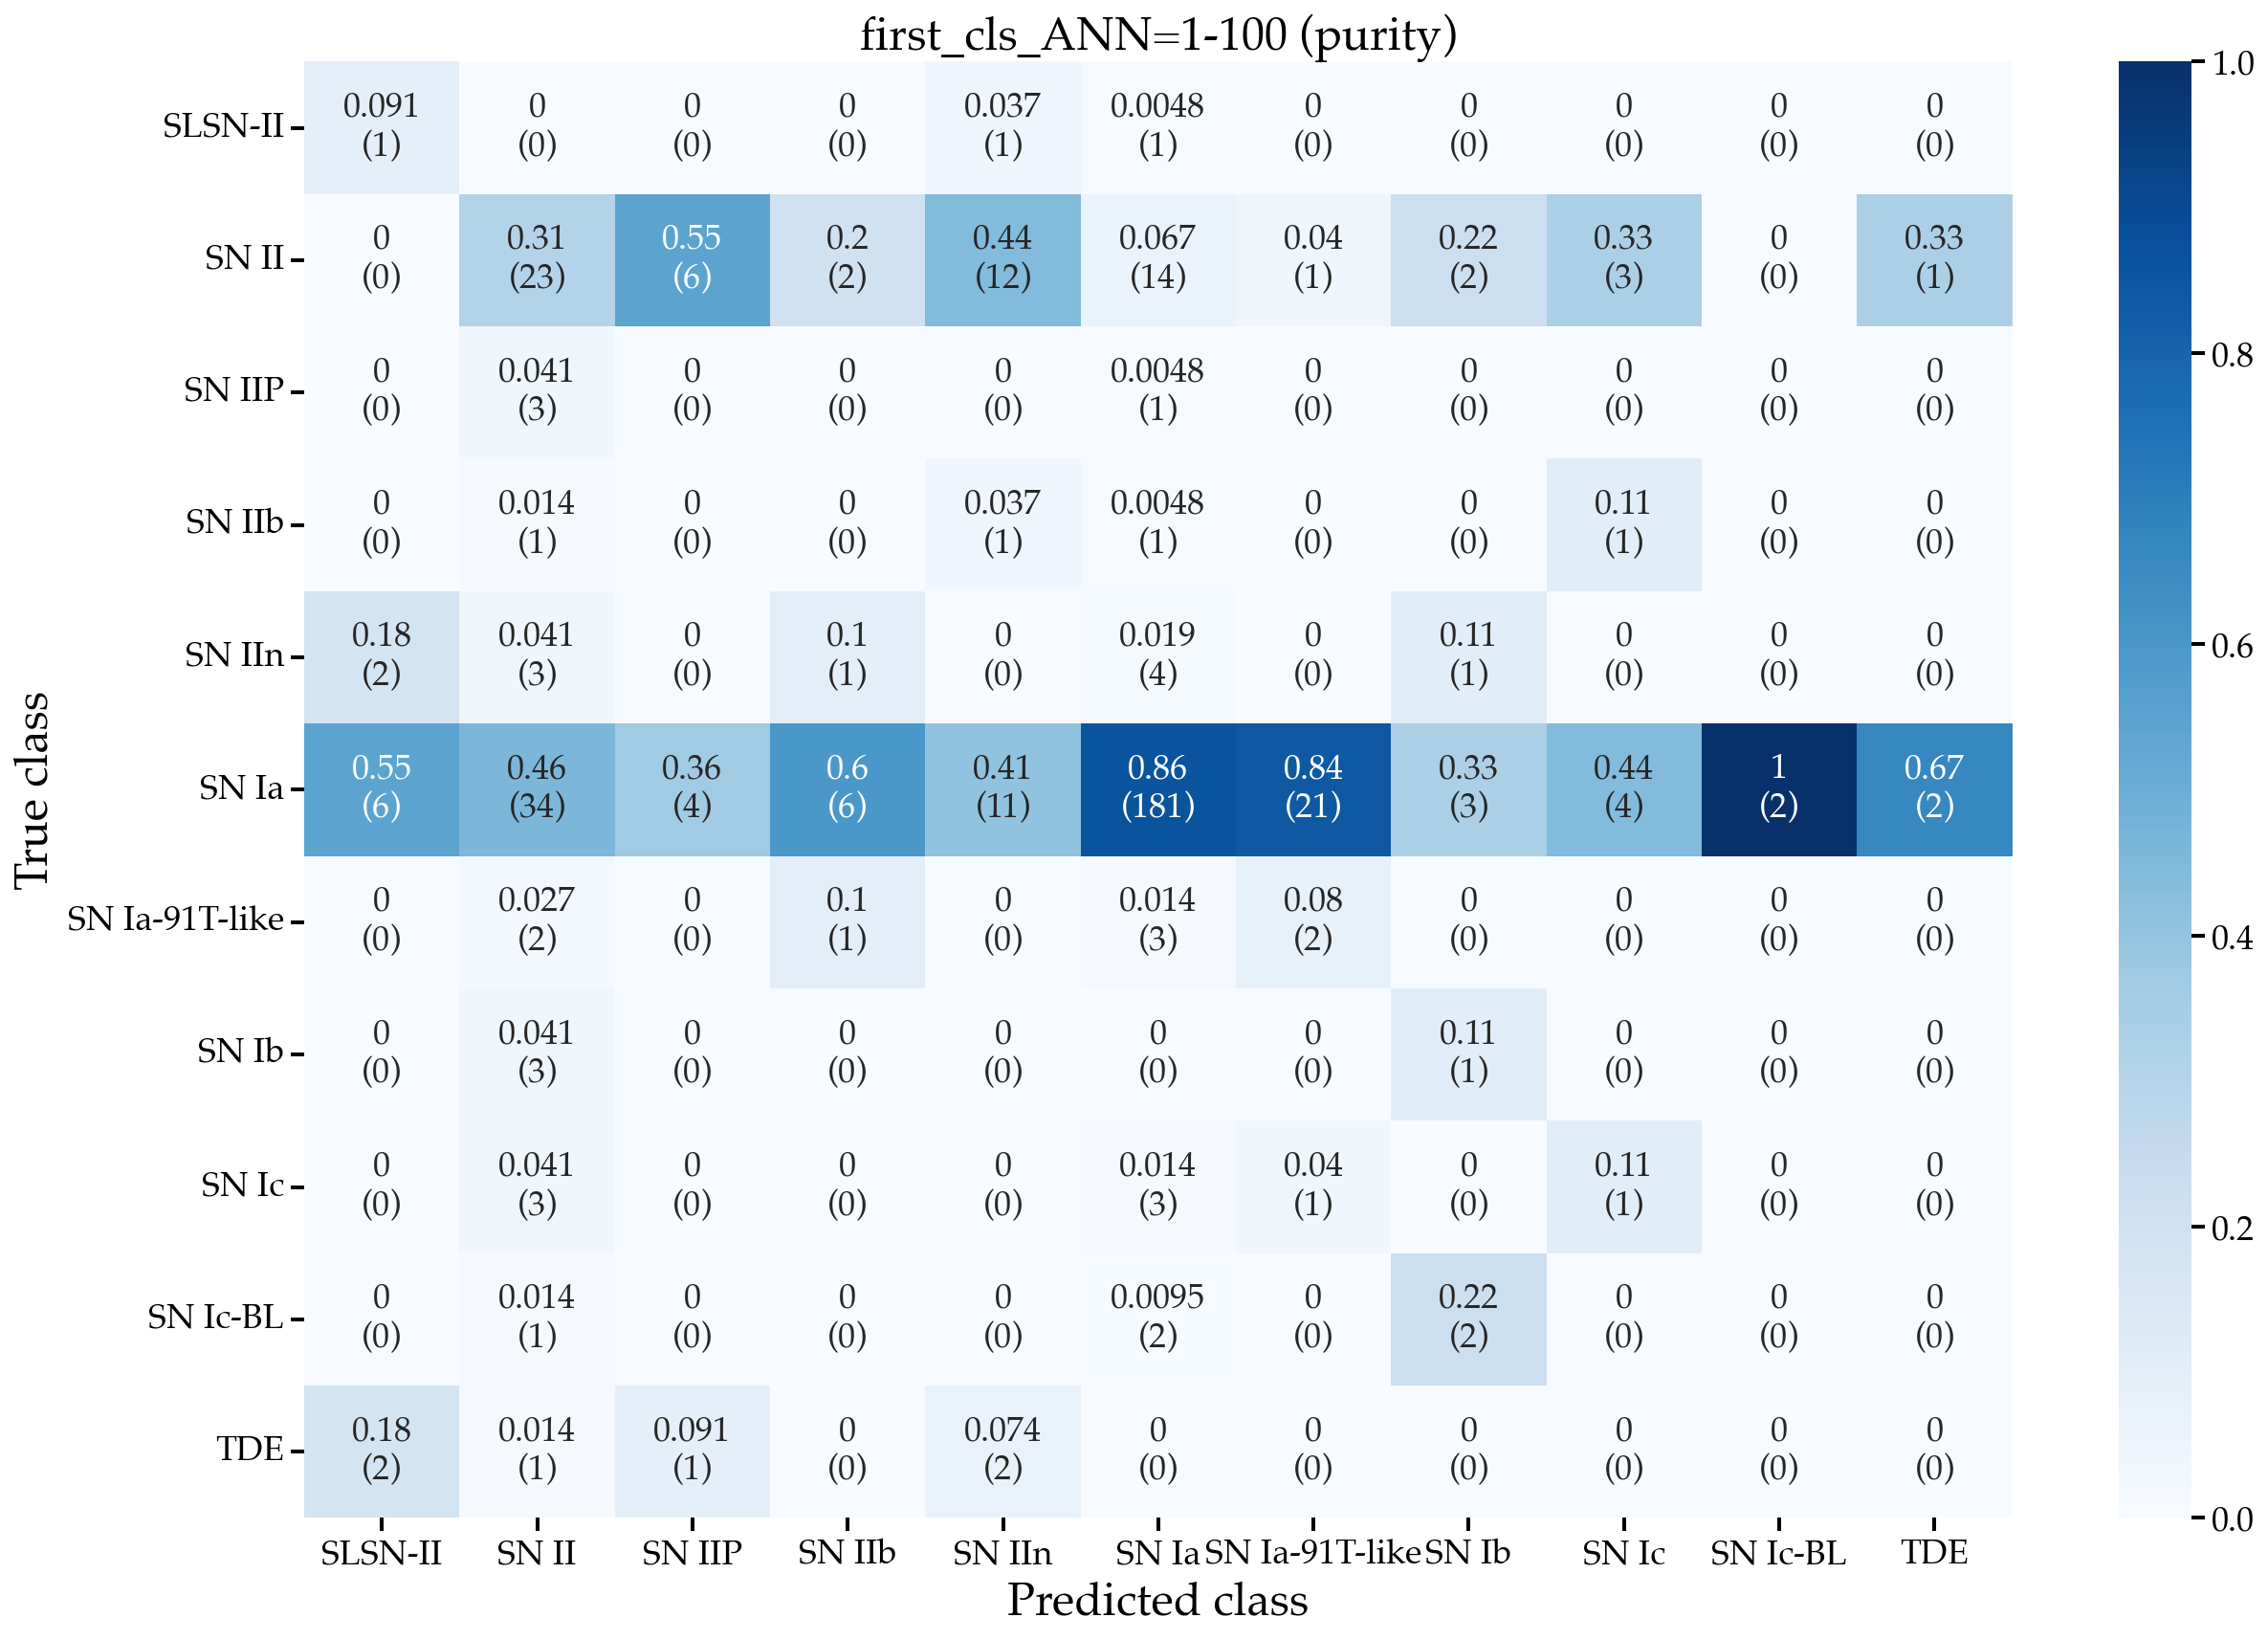

In [14]:
# Confusion matrices
df = ann0_ann1_df_noNone
true_labels = np.array(df['ann=0_tns_cls'])
predicted_labels = np.array(df['ann=1_tns_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND)
    plt.savefig(f'../figures/graphs/{suffix}/confmatrix_nclasses={nclasses}_noNone_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

### Group by similar classes
#### I.e. Ia-norm, Ia-pec, Ia-91T --> Ia

In [15]:
class_names

array(['SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [16]:
sim_class_di = {'CV': 'CV', 
      'SLSN-I': 'SLSN', 
      'SLSN-II': 'SLSN', 
      'SN II': 'SN II', 
      'SN IIP': 'SN II', 
      'SN IIb': 'SN II', 
      'SN IIn': 'SN II',
      'SN Ia': 'SN Ia', 
      'SN Ia-91T-like': 'SN Ia', 
      'SN Ia-pec': 'SN Ia', 
      'SN Ia-CSM': 'SN Ia',
      'SN Ia-91bg-like': 'SN Ia',
      'SN Ib': 'SN Ibc', 
      'SN Ib/c': 'SN Ibc',
      'SN Ibn': 'SN Ibc', 
      'SN Ic': 'SN Ibc',
      'SN Ic-BL': 'SN Ibc', 
      'TDE': 'TDE',
      'None': 'None',
      'SN': 'SN',
      'SN I': 'SN I',
      'Other': 'Other',
      'AGN': 'AGN'}

ann0_ann1_df_noNone_sim_class = ann0_ann1_df_noNone.copy()
ann0_ann1_df_noNone_sim_class['ann=0_tns_cls'] = ann0_ann1_df_noNone_sim_class['ann=0_tns_cls'].map(sim_class_di)
ann0_ann1_df_noNone_sim_class['ann=1_tns_cls'] = ann0_ann1_df_noNone_sim_class['ann=1_tns_cls'].map(sim_class_di)
#ann0_ann1_df_noNone_sim_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_sim_class['most_common_cls_ann=1-100'].map(sim_class_di)

In [17]:
ann0_ann1_df_noNone_sim_class

,ann=0_tns_cls,ann=1_tns_cls
ZTF21aazebgh,SN Ia,SN Ia
ZTF21acgxypn,SN Ibc,SN Ibc
ZTF19aapqqrb,SN Ia,None
ZTF21aasbxng,SN Ia,SN Ia
ZTF21aaglgcb,SN Ia,SN Ia
...,...,...
ZTF21acdalyp,SN Ia,SN Ia
ZTF21abdcauj,SN Ia,SN Ia
ZTF21aaetnfe,SN Ia,SN Ia
ZTF21acgzwsc,SN Ia,SN II


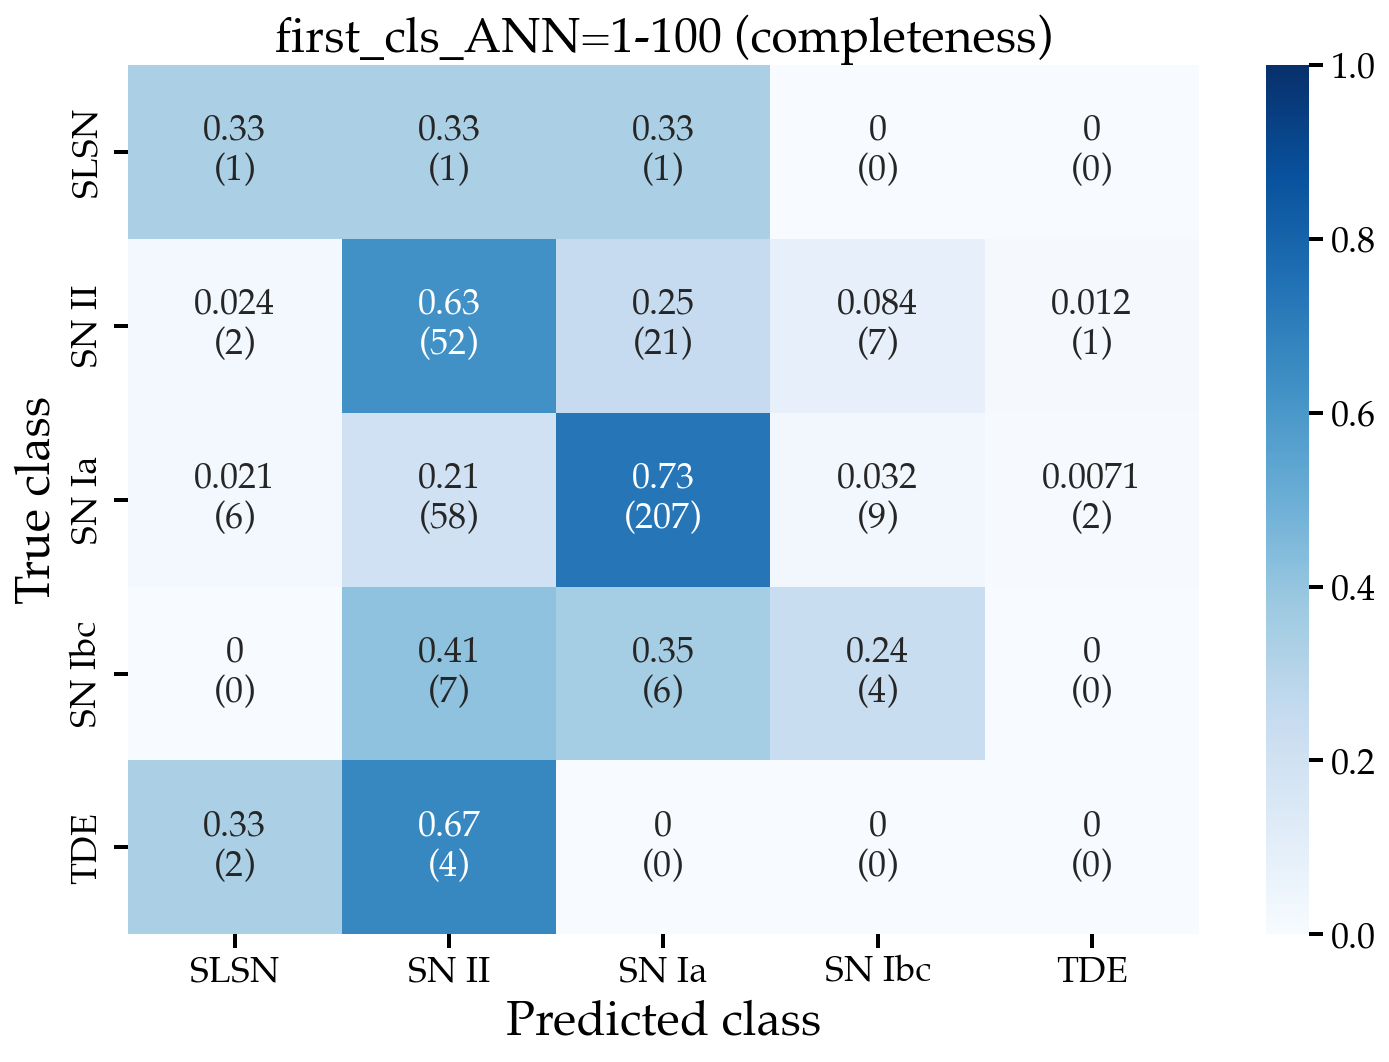

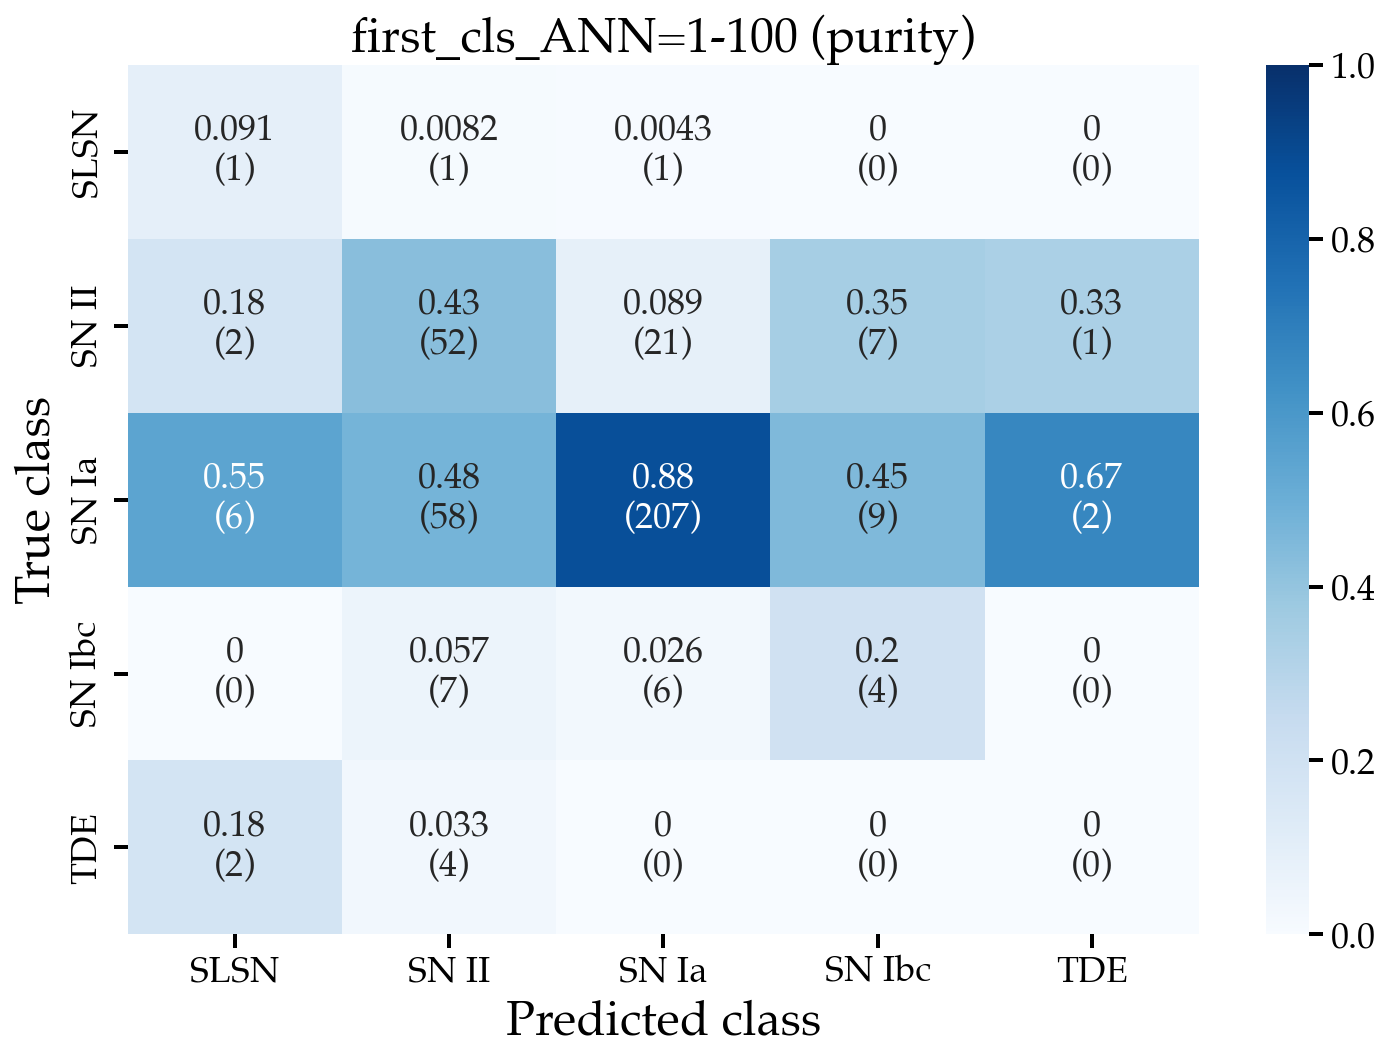

In [18]:
# Confusion matrices
df = ann0_ann1_df_noNone_sim_class
true_labels = np.array(df['ann=0_tns_cls'])
predicted_labels = np.array(df['ann=1_tns_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(12, 8))
    plt.savefig(f'../figures/graphs/{suffix}/confmatrix_nclasses={nclasses}_noNone_similar_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [19]:
### CC vs Ia vs Exotic (TDE, SLSN)

bin_class_di = {'CV': 'CV', 
      'SLSN-I': 'Exotic', 
      'SLSN-II': 'Exotic', 
      'SN II': 'SN CC', 
      'SN IIP': 'SN CC', 
      'SN IIb': 'SN CC', 
      'SN IIn': 'SN CC',
      'SN Ia': 'SN Ia', 
      'SN Ia-91T-like': 'SN Ia', 
      'SN Ia-pec': 'SN Ia', 
      'SN Ia-CSM': 'SN Ia',
      'SN Ia-91bg-like': 'SN Ia',
      'SN Ib': 'SN CC', 
      'SN Ib/c': 'SN CC',
      'SN Ibn': 'SN CC', 
      'SN Ic': 'SN CC',
      'SN Ic-BL': 'SN CC', 
      'TDE': 'Exotic',
      'None': 'None',
      'SN': 'Other',
      'SN I': 'Other',
      'Other': 'Other',
      'AGN': 'AGN'}

ann0_ann1_df_noNone_bin_class = ann0_ann1_df_noNone.copy()
ann0_ann1_df_noNone_bin_class['ann=0_tns_cls'] = ann0_ann1_df_noNone_bin_class['ann=0_tns_cls'].map(bin_class_di)
ann0_ann1_df_noNone_bin_class['ann=1_tns_cls'] = ann0_ann1_df_noNone_bin_class['ann=1_tns_cls'].map(bin_class_di)
#ann0_ann1_df_noNone_bin_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_bin_class['most_common_cls_ann=1-100'].map(bin_class_di)

In [20]:
mask = (ann0_ann1_df_noNone_bin_class['ann=0_tns_cls'] != 'AGN') & (ann0_ann1_df_noNone_bin_class['ann=0_tns_cls'] != 'CV') & (ann0_ann1_df_noNone_bin_class['ann=0_tns_cls'] != 'Other')
ann0_ann1_df_noNone_bin_class = ann0_ann1_df_noNone_bin_class[mask]
ann0_ann1_df_noNone_bin_class

,ann=0_tns_cls,ann=1_tns_cls
ZTF21aazebgh,SN Ia,SN Ia
ZTF21acgxypn,SN CC,SN CC
ZTF19aapqqrb,SN Ia,None
ZTF21aasbxng,SN Ia,SN Ia
ZTF21aaglgcb,SN Ia,SN Ia
...,...,...
ZTF21acdalyp,SN Ia,SN Ia
ZTF21abdcauj,SN Ia,SN Ia
ZTF21aaetnfe,SN Ia,SN Ia
ZTF21acgzwsc,SN Ia,SN CC


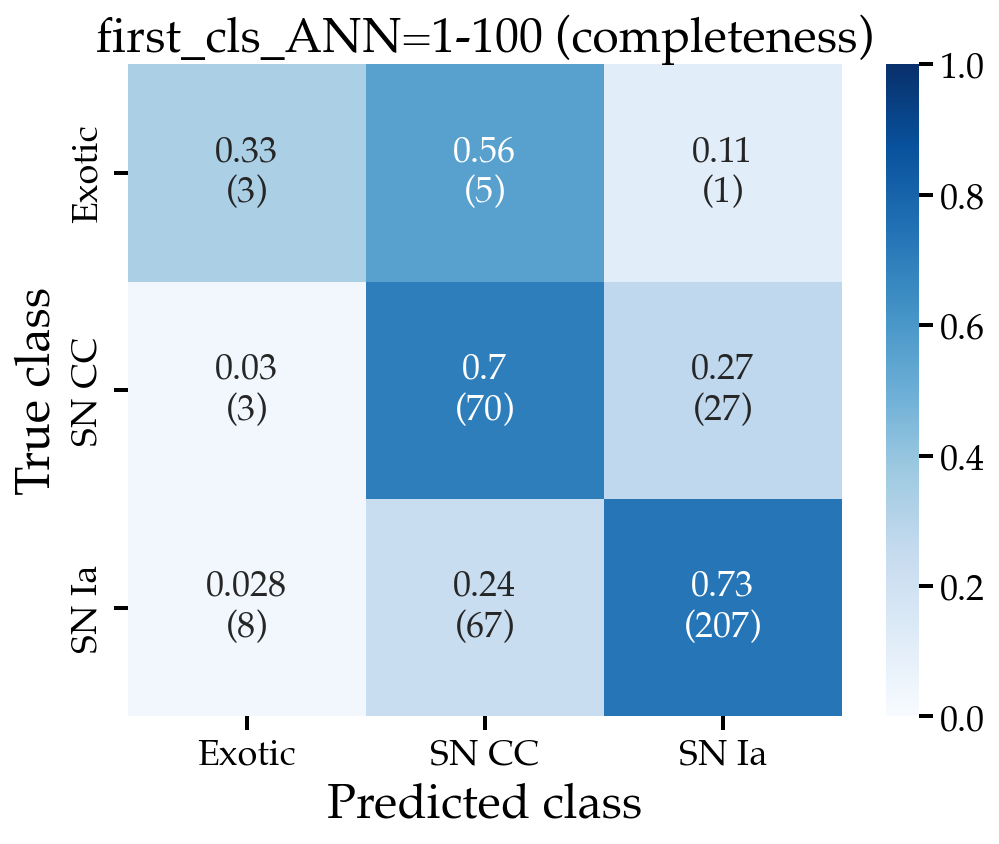

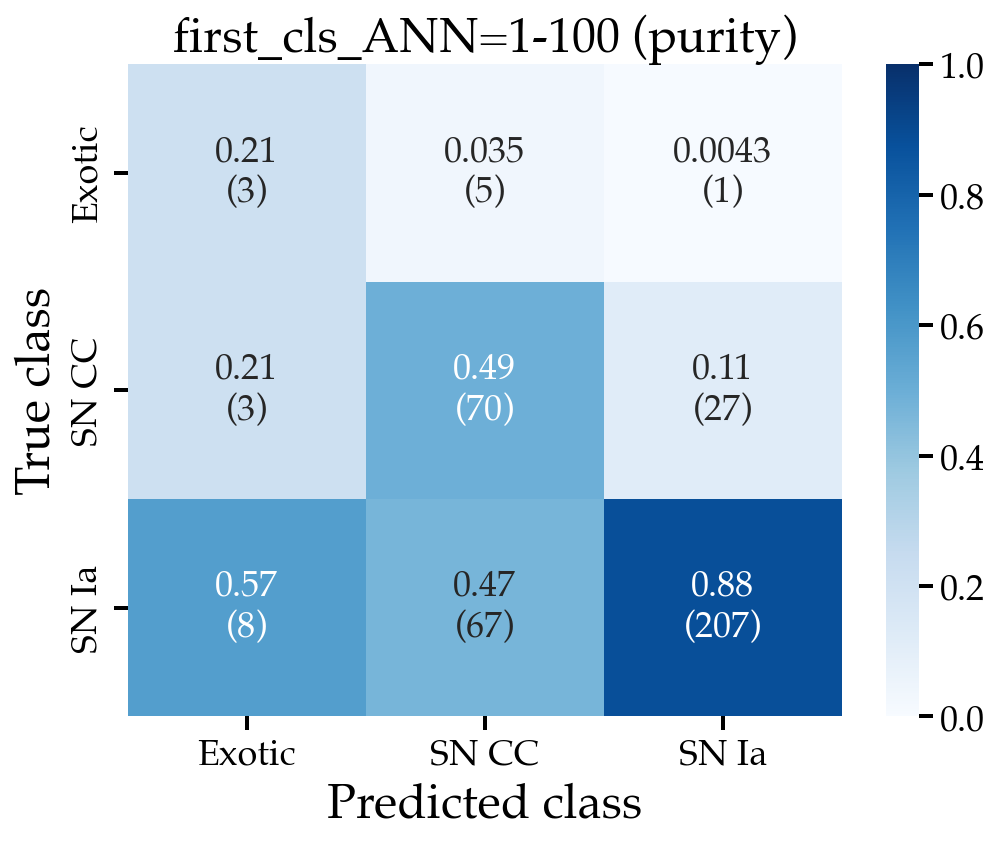

In [21]:
# Confusion matrices
df = ann0_ann1_df_noNone_bin_class
true_labels = np.array(df['ann=0_tns_cls'])
predicted_labels = np.array(df['ann=1_tns_cls'])#np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(8, 6))
    plt.savefig(f'../figures/graphs/{suffix}/confmatrix_nclasses={nclasses}_noNone_binary_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

### Rare vs Non rare classes (basically not-Ia-norm vs Ia-norm)

In [22]:
rare_v_not_class_di = {'CV': 'Not SN', 
      'SLSN-I': 'Rare', 
      'SLSN-II': 'Rare', 
      'SN II': 'Rare', 
      'SN IIP': 'Rare', 
      'SN IIb': 'Rare', 
      'SN IIn': 'Rare',
      'SN Ia': 'NOT Rare', 
      'SN Ia-91T-like': 'Rare', 
      'SN Ia-CSM': 'Rare',
      'SN Ia-91bg-like': 'Rare',
      'SN Ia-pec': 'Rare', 
      'SN Ib': 'Rare', 
      'SN Ib/c': 'Rare',
      'SN Ibn': 'Rare',
      'SN Ic': 'Rare',
      'SN Ic-BL': 'Rare', 
      'TDE': 'Rare',
      'None': 'NOT Rare',
      'SN': 'Other',
      'SN I': 'Other',
      'Other': 'Other',
      'AGN': 'Not SN'}


ann0_ann1_df_noNone_rare_v_not_class = ann0_ann1_df_noNone.copy()
ann0_ann1_df_noNone_rare_v_not_class['ann=0_tns_cls'] = ann0_ann1_df_noNone_rare_v_not_class['ann=0_tns_cls'].map(rare_v_not_class_di)
ann0_ann1_df_noNone_rare_v_not_class['ann=1_tns_cls'] = ann0_ann1_df_noNone_rare_v_not_class['ann=1_tns_cls'].map(rare_v_not_class_di)
#ann0_ann1_df_noNone_rare_v_not_class['most_common_cls_ann=1-100'] = ann0_ann1_df_noNone_rare_v_not_class['most_common_cls_ann=1-100'].map(rare_v_not_class_di)

In [23]:
mask = (ann0_ann1_df_noNone_rare_v_not_class['ann=0_tns_cls'] != 'Not SN') & (ann0_ann1_df_noNone_rare_v_not_class['ann=0_tns_cls'] != 'Other')
ann0_ann1_df_noNone_rare_v_not_class = ann0_ann1_df_noNone_rare_v_not_class[mask]
ann0_ann1_df_noNone_rare_v_not_class

,ann=0_tns_cls,ann=1_tns_cls
ZTF21aazebgh,NOT Rare,NOT Rare
ZTF21acgxypn,Rare,Rare
ZTF19aapqqrb,NOT Rare,NOT Rare
ZTF21aasbxng,NOT Rare,NOT Rare
ZTF21aaglgcb,NOT Rare,NOT Rare
...,...,...
ZTF21acdalyp,Rare,NOT Rare
ZTF21abdcauj,NOT Rare,NOT Rare
ZTF21aaetnfe,NOT Rare,NOT Rare
ZTF21acgzwsc,NOT Rare,Rare


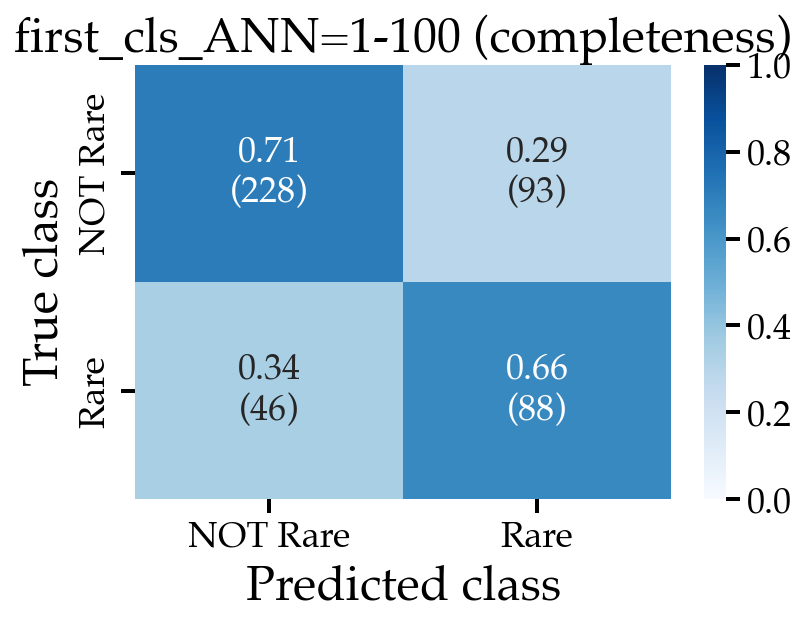

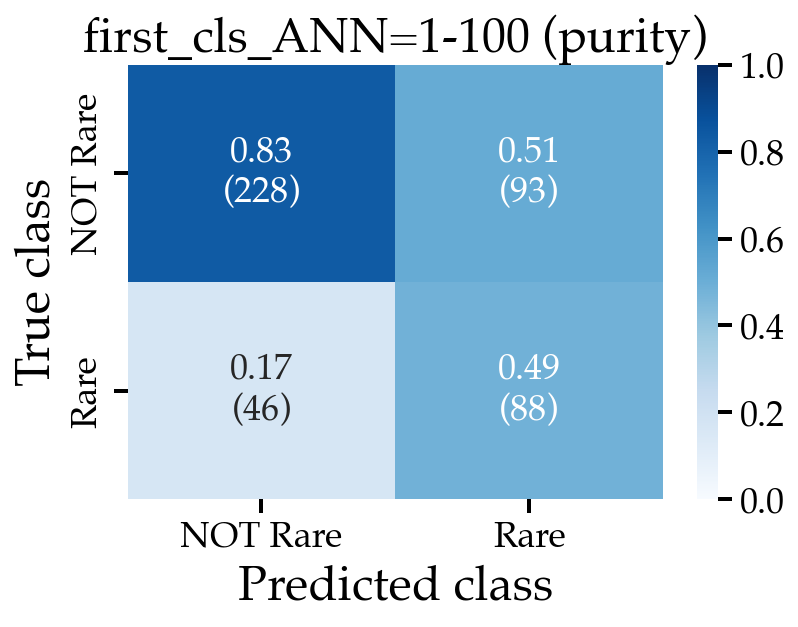

In [24]:
# Confusion matrices
df = ann0_ann1_df_noNone_rare_v_not_class
true_labels = np.array(df['ann=0_tns_cls'])
predicted_labels = np.array(df['ann=1_tns_cls']) #np.array(df['most_common_cls_ann=1-100']) # np.array(df['ann=1_tns_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['completeness', 'purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'{title} ({KIND})', kind=KIND, figsize=(6, 4))
    plt.savefig(f'../figures/graphs/{suffix}/confmatrix_nclasses={nclasses}_noNone_rare_v_not_class_{title}_{KIND}.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()